In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import math


from pandas.tools.plotting import scatter_matrix

In [3]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [4]:
#
# Combines all of the individual frames into one dataframe, combining on the "Gene" column
# Column names are the data file
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [5]:
#
# Sort columns by name for convenience
#

df = df.reindex(sorted(df.columns), axis=1)

In [6]:
#
# Use only genes starting with "Y" which are protein-coding genes
# You can come back and revisit this choice later if you want
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [7]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [8]:
# Save so we don't have to do all that again next time

df.to_csv("Barton_combined_Ygenes.txt", sep='\t')

In [9]:
# remove outliers 

colnames = df.columns.get_values()

colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep06 0.691487784223
Removing  Snf2_rep13 0.803427905697
Removing  Snf2_rep35 0.932471392569
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  WT_rep25 0.86363576014
Removing  WT_rep28 0.891720439048


In [10]:
# now create lists for WT and Snf2 so we can start comparing them

colnames_snf2 = []
colnames_WT = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)

In [11]:
# for convenience, create new columns that are averages of each type and overall

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)



In [12]:
#
# time to relook at normalization
#

df['Gmean'] = gmean(df.loc[:,colnames_WT],axis=1)


In [13]:
colnorm = {}

for c in colnames:
    colnorm[c] = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())

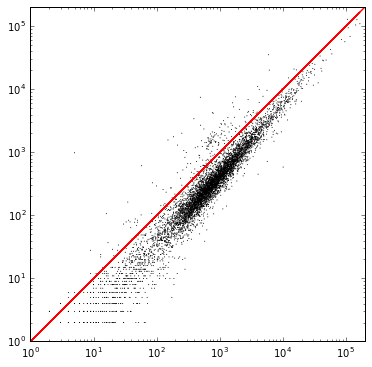

In [14]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

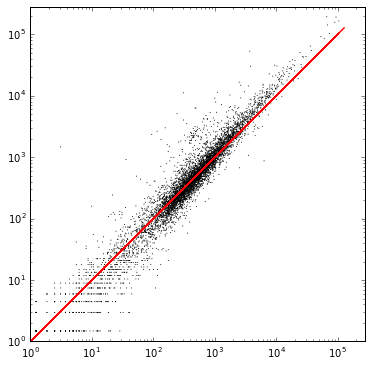

In [15]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]/colnorm[c1]
y = df[c2]/colnorm[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

In [16]:
for c in colnames:
    df[c] = df[c]/colnorm[c]

In [17]:
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['WT_var'] = df[colnames_WT].var(axis=1)
df['WT_sum'] = df[colnames_WT].sum(axis=1)
df['WT_std'] = df[colnames_WT].std(axis=1)

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['Snf2_var'] = df[colnames_snf2].var(axis=1)
df['Snf2_sum'] = df[colnames_snf2].sum(axis=1)

df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)
df['var'] = df[colnames_snf2 + colnames_WT].var(axis=1)
df['sum'] = df[colnames_snf2 + colnames_WT].sum(axis=1)

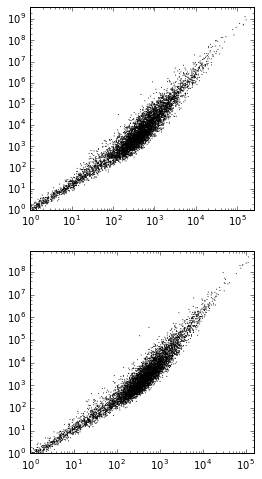

In [18]:
fig,axes = plt.subplots(2,1,figsize = (4,8))
x = df['WT_ave']
y = df['WT_var']

maxval = max(np.max(x),np.max(y))
axes[0].set_xlim(1,np.max(x))
axes[0].set_ylim(1,np.max(y))
axes[0].set_xscale("log", nonposx='clip')
axes[0].set_yscale("log", nonposx='clip')
axes[0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_var']

maxval = max(np.max(x),np.max(y))
axes[1].set_xlim(1,np.max(x))
axes[1].set_ylim(1,np.max(y))
axes[1].set_xscale("log", nonposx='clip')
axes[1].set_yscale("log", nonposx='clip')
axes[1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

In [20]:
colnames_WT_t = list(np.random.choice(colnames_WT,3))
colnames_snf2_t = list(np.random.choice(colnames_snf2,3))

df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

df['ave_t'] = df[colnames_snf2_t + colnames_WT_t].mean(axis=1)
df['var_t'] = df[colnames_snf2_t + colnames_WT_t].var(axis=1)
df['sum_t'] = df[colnames_snf2_t + colnames_WT_t].sum(axis=1)

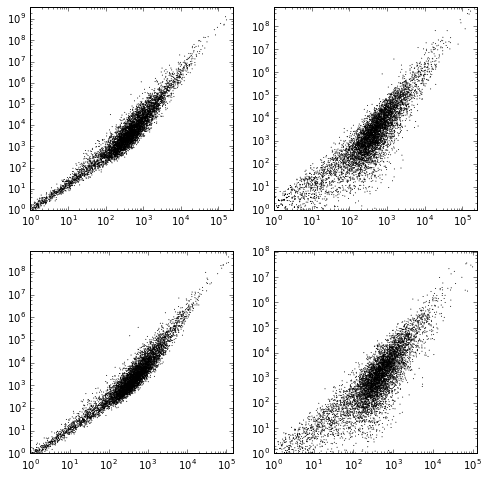

In [21]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = df['WT_ave']
y = df['WT_var']

maxval = max(np.max(x),np.max(y))
axes[0][0].set_xlim(1,np.max(x))
axes[0][0].set_ylim(1,np.max(y))
axes[0][0].set_xscale("log", nonposx='clip')
axes[0][0].set_yscale("log", nonposx='clip')
axes[0][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_var']

maxval = max(np.max(x),np.max(y))
axes[1][0].set_xlim(1,np.max(x))
axes[1][0].set_ylim(1,np.max(y))
axes[1][0].set_xscale("log", nonposx='clip')
axes[1][0].set_yscale("log", nonposx='clip')
axes[1][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['WT_ave_t']
y = df['WT_var_t']

maxval = max(np.max(x),np.max(y))
axes[0][1].set_xlim(1,np.max(x))
axes[0][1].set_ylim(1,np.max(y))
axes[0][1].set_xscale("log", nonposx='clip')
axes[0][1].set_yscale("log", nonposx='clip')
axes[0][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave_t']
y = df['Snf2_var_t']

maxval = max(np.max(x),np.max(y))
axes[1][1].set_xlim(1,np.max(x))
axes[1][1].set_ylim(1,np.max(y))
axes[1][1].set_xscale("log", nonposx='clip')
axes[1][1].set_yscale("log", nonposx='clip')
axes[1][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

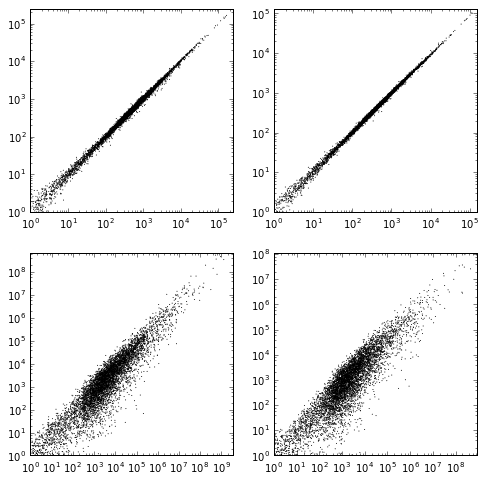

In [22]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = df['WT_ave']
y = df['WT_ave_t']
i = 0
j = 0

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['WT_var']
y = df['WT_var_t']
i = 1
j = 0

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_ave_t']
i = 0
j = 1

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_var']
y = df['Snf2_var_t']
i = 1
j = 1

maxval = max(np.max(x),np.max(y))
axes[i][j].set_xlim(1,np.max(x))
axes[i][j].set_ylim(1,np.max(y))
axes[i][j].set_xscale("log", nonposx='clip')
axes[i][j].set_yscale("log", nonposx='clip')
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')

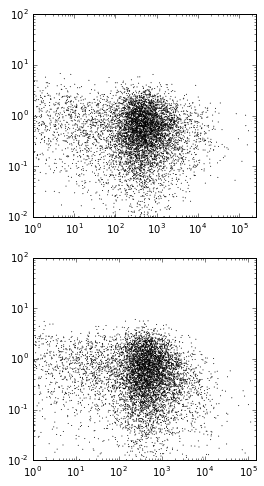

In [23]:
fig,axes = plt.subplots(2,1,figsize = (4,8))

x = df['WT_ave']
y = df['WT_var_t'] / df['WT_var']
i = 0

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
axes[i].set_ylim(.01,100)
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_ave']
y = df['Snf2_var_t'] / df['Snf2_var']
i = 1

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
axes[i].set_ylim(.01,100)
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')



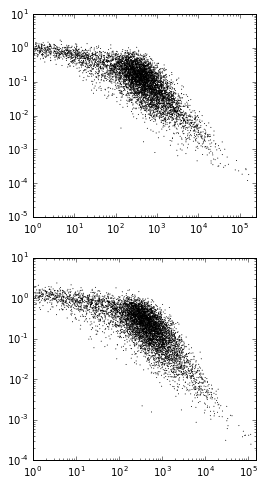

In [24]:
fig,axes = plt.subplots(2,1,figsize = (4,8))

x = df['WT_ave']
y = df['WT_ave']/df['WT_var']
i = 0

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
#axes[i].set_ylim(1,np.max(y))
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


x = df['Snf2_ave']
y = df['Snf2_ave']/df['Snf2_var']
i = 1

maxval = max(np.max(x),np.max(y))
axes[i].set_xlim(1,np.max(x))
#axes[i].set_ylim(1,np.max(y))
axes[i].set_xscale("log", nonposx='clip')
axes[i].set_yscale("log", nonposx='clip')
axes[i].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')


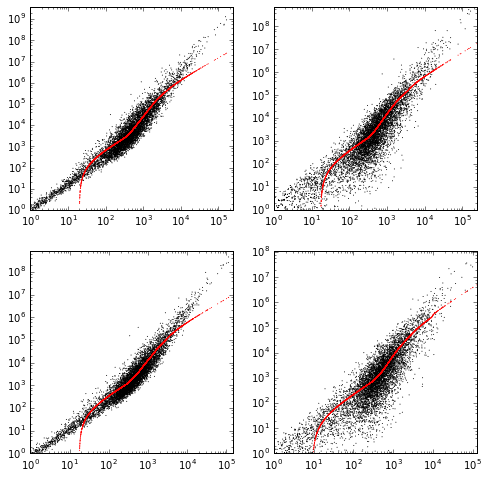

In [25]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = df['WT_ave']
y = df['WT_var']
out = lowess(y,x)

maxval = max(np.max(x),np.max(y))
axes[0][0].set_xlim(1,np.max(x))
axes[0][0].set_ylim(1,np.max(y))
axes[0][0].set_xscale("log", nonposx='clip')
axes[0][0].set_yscale("log", nonposx='clip')
axes[0][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[0][0].scatter(out[:,0],out[:,1],s = 1, c='red', edgecolor = 'none')

x = df['Snf2_ave']
y = df['Snf2_var']
out = lowess(y,x)

maxval = max(np.max(x),np.max(y))
axes[1][0].set_xlim(1,np.max(x))
axes[1][0].set_ylim(1,np.max(y))
axes[1][0].set_xscale("log", nonposx='clip')
axes[1][0].set_yscale("log", nonposx='clip')
axes[1][0].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[1][0].scatter(out[:,0],out[:,1],s = 1, c='red', edgecolor = 'none')

x = df['WT_ave_t']
y = df['WT_var_t']
out = lowess(y,x)

maxval = max(np.max(x),np.max(y))
axes[0][1].set_xlim(1,np.max(x))
axes[0][1].set_ylim(1,np.max(y))
axes[0][1].set_xscale("log", nonposx='clip')
axes[0][1].set_yscale("log", nonposx='clip')
axes[0][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[0][1].scatter(out[:,0],out[:,1],s = 1, c='red', edgecolor = 'none')

x = df['Snf2_ave_t']
y = df['Snf2_var_t']
out = lowess(y,x)

maxval = max(np.max(x),np.max(y))
axes[1][1].set_xlim(1,np.max(x))
axes[1][1].set_ylim(1,np.max(y))
axes[1][1].set_xscale("log", nonposx='clip')
axes[1][1].set_yscale("log", nonposx='clip')
axes[1][1].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[1][1].scatter(out[:,0],out[:,1],s = 1, c='red', edgecolor = 'none')

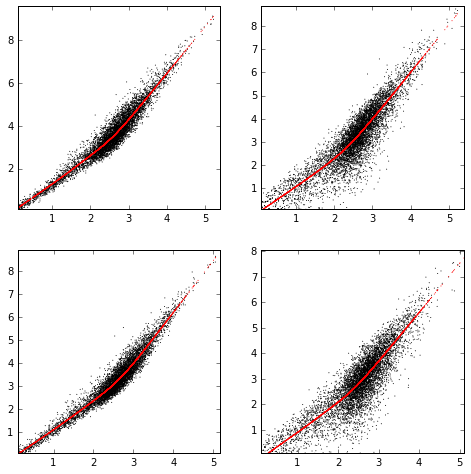

In [26]:
fig,axes = plt.subplots(2,2,figsize = (8,8))

x = np.log10(df['WT_ave'])
y = np.log10(df['WT_var'])
lowout = lowess(y,x)

i = 0
j = 0
axes[i][j].set_xlim(.1,np.max(x))
axes[i][j].set_ylim(.1,np.max(y))
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[i][j].scatter(lowout[:,0],lowout[:,1],s = 1, c='red', edgecolor = 'none')

x = np.log10(df['Snf2_ave'])
y = np.log10(df['Snf2_var'])
lowout = lowess(y,x)

i = 1
j = 0
axes[i][j].set_xlim(.1,np.max(x))
axes[i][j].set_ylim(.1,np.max(y))
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[i][j].scatter(lowout[:,0],lowout[:,1],s = 1, c='red', edgecolor = 'none')

x = np.log10(df['WT_ave_t'])
y = np.log10(df['WT_var_t'])
lowout = lowess(y,x)

i = 0
j = 1
axes[i][j].set_xlim(.1,np.max(x))
axes[i][j].set_ylim(.1,np.max(y))
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[i][j].scatter(lowout[:,0],lowout[:,1],s = 1, c='red', edgecolor = 'none')

x = np.log10(df['Snf2_ave_t'])
y = np.log10(df['Snf2_var_t'])
lowout = lowess(y,x)

i = 1
j = 1
axes[i][j].set_xlim(.1,np.max(x))
axes[i][j].set_ylim(.1,np.max(y))
axes[i][j].scatter(x,y, s = 1, c = 'black', edgecolor = 'none')
axes[i][j].scatter(lowout[:,0],lowout[:,1],s = 1, c='red', edgecolor = 'none')

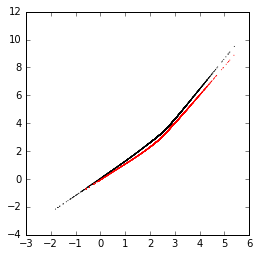

In [27]:
x = np.log10(df['WT_ave'])
y = np.log10(df['WT_var'])
lowout_wt = lowess(y,x)

x = np.log10(df['WT_ave_t'])
y = np.log10(df['WT_var_t'])
lowout_wt_t = lowess(y,x)

fig,ax = plt.subplots(1,1,figsize = (4,4))

ax.scatter(lowout_wt[:,0],lowout_wt[:,1],s = 1, c='black', edgecolor = 'none')
ax.scatter(lowout_wt_t[:,0],lowout_wt_t[:,1],s = 1, c='red', edgecolor = 'none')


In [43]:
x = np.log(df['WT_ave'])
y = np.log(df['WT_var'])
df['WT_var_low'] = np.exp(lowess(y,x,return_sorted = False))

x = np.log(df['WT_ave_t'])
y = np.log(df['WT_var_t'])
df['WT_var_t_low'] = np.exp(lowess(y,x,return_sorted = False))

x = np.log(df['Snf2_ave'])
y = np.log(df['Snf2_var'])
df['Snf2_var_low'] = np.exp(lowess(y,x,return_sorted = False))

x = np.log(df['Snf2_ave_t'])
y = np.log(df['Snf2_var_t'])
df['Snf2_var_t_low'] = np.exp(lowess(y,x,return_sorted = False))

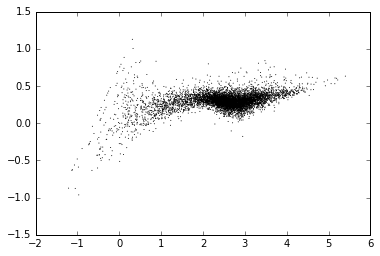

In [44]:
x = np.log10(df['WT_ave'])
y = np.log10(df['WT_var_low']/df['WT_var_t_low'])

plt.scatter(x,y,s = 1, c='black', edgecolor = 'none')

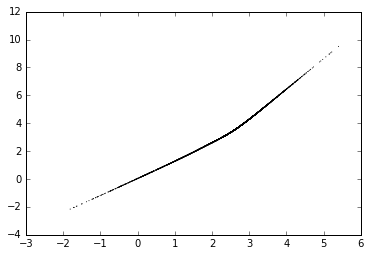

In [45]:
x = np.log10(df['WT_ave'])
y = np.log10(df['WT_var_low'])

plt.scatter(x,y,s = 1, c='black', edgecolor = 'none')

In [ ]:
x = np.log10(df['WT_ave'])
y = np.log10(df['WT_var'])
lowout_wt = lowess(y,x)

x = np.log10(df['WT_ave_t'])
y = np.log10(df['WT_var_t'])
lowout_wt_t = lowess(y,x)

fig,ax = plt.subplots(1,1,figsize = (4,4))

ax.scatter(lowout_wt[:,0],lowout_wt[:,1],s = 1, c='black', edgecolor = 'none')
ax.scatter(lowout_wt_t[:,0],lowout_wt_t[:,1],s = 1, c='red', edgecolor = 'none')


In [ ]:
# let's look at what kind of distribution best describes the data

df2 = df[colnames_WT].subtract(df['WT_ave'],axis=0).divide(df['WT_std'],axis=0)
df2 = df2[df['WT_ave'] > 100]

In [ ]:
data = np.ravel(df2.replace([np.inf, -np.inf], np.nan).dropna().values)
h = plt.hist(data,bins=50)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

mean_fit, var_fit = norm.fit(data)

rv = norm(mean_fit,var_fit)
x = np.linspace(rv.ppf(0.001),rv.ppf(0.999), 100)

ax.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(data, normed=True, histtype='stepfilled', bins = 100, alpha=0.2)
ax.legend(loc='best', frameon=False)
df[plt.show()

In [ ]:
n1 = float(len(colnames_WT))
n2 = float(len(colnames_snf2))

df['z_score'] = df['colnames_']



for index, row in df.iterrows():
    snf2 = row[colnames_snf2]
    wt = row[colnames_WT]
    
    #zscore = (np.mean(wt)-np.mean(snf2))/np.sqrt((row['WT_var']/n1) + (row['Snf2_var']/n2))
    if not math.isnan(zscore):
        row['z_score'] = zscore

In [ ]:
n1 = float(len(colnames_WT))
n2 = float(len(colnames_snf2))

df['z_score'] = (df[colnames_WT].mean(axis=1) - df[colnames_snf2].mean(axis=1))/np.sqrt((df['WT_var']/n1) + (df['Snf2_var']/n2))

In [ ]:
data = df['z_score']
h = plt.hist(data,bins=np.arange(-50,50,1))

In [ ]:
colnames_WT_t = list(np.random.choice(colnames_WT,20))
colnames_snf2_t = list(np.random.choice(colnames_snf2,20))

df['WT_ave_t'] = df[colnames_WT_t].mean(axis=1)
df['WT_var_t'] = df[colnames_WT_t].var(axis=1)
df['WT_sum_t'] = df[colnames_WT_t].sum(axis=1)


df['Snf2_ave_t'] = df[colnames_snf2_t].mean(axis=1)
df['Snf2_var_t'] = df[colnames_snf2_t].var(axis=1)
df['Snf2_sum_t'] = df[colnames_snf2_t].sum(axis=1)

df['ave_t'] = df[colnames_snf2_t + colnames_WT_t].mean(axis=1)
df['var_t'] = df[colnames_snf2_t + colnames_WT_t].var(axis=1)
df['sum_t'] = df[colnames_snf2_t + colnames_WT_t].sum(axis=1)

n1 = float(len(colnames_WT_t))
n2 = float(len(colnames_snf2_t))

df['z_score_t'] = (df[colnames_WT_t].mean(axis=1) - df[colnames_snf2_t].mean(axis=1))/np.sqrt((df['WT_var_t']/n1) + (df['Snf2_var_t']/n2))

In [ ]:
data = df['z_score_t']
h = plt.hist(data,bins=np.arange(-50,50,1))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(df['z_score'],df['z_score_t'])
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)

In [ ]:
# lets look at individual genes a bit closer

gene = 'YCR009C'

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(df.at[gene,c])
for c in colnames_WT:
    wt.append(df.at[gene,c])
        
h = plt.hist(wt, color = 'blue',label='WT')
h = plt.hist(snf2, color = 'red',label='SNF2')
plt.legend()

In [ ]:
# log transform values

gene = 'YCR009C'

snf2 = []
wt = []


for c in colnames_snf2:
    snf2.append(np.log10(df.at[gene,c]))
for c in colnames_WT:
    wt.append(np.log10(df.at[gene,c]))
        
h = plt.hist(wt,color = 'blue',label='WT')
h = plt.hist(snf2,color = 'red',label='SNF2')
plt.legend()

In [ ]:
samplesizes = [1,2,3,4,5,10,25,50,100]
trials = 1000
ave = 1000
var = 100

meandiffs = {}

for s in samplesizes:
    meandiffs[s] = []
    for t in range(0,trials):
        s1 = rv.rvs(size=s)
        s2 = rv.rvs(size=s)
        meandiffs[s].append(abs(np.mean(s1)-np.mean(s2)))
        
        


In [ ]:
plt.hist(meandiffs[1], normed=True)
plt.hist(meandiffs[2], normed=True)
plt.hist(meandiffs[10], normed=True)
plt.hist(meandiffs[100], normed=True)

In [ ]:
fig, ax = plt.subplots(1, 1)

mean, var, skew, kurt = norm.stats(moments='mvsk')

print (mean,var)
rv = norm(10,10)

x = np.linspace(rv.ppf(0.001),rv.ppf(0.999), 100)

ax.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='norm pdf')

r = rv.rvs(size=100)
ax.hist(r, normed=True, histtype='stepfilled', bins = 10, alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(8,12))

for c,mean in enumerate([0,100]):
    for r,var in enumerate([1,2,3]):
        rv = norm(mean,var)
        x = np.linspace(norm(mean,3).ppf(0.001),norm(mean,3).ppf(0.999), 100)
        axes[r][c].plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label="%d,%d" % (mean,var))
        axes[r][c].legend(loc='best', frameon=False)


In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

s = 1000

data = norm_true.rvs(size=s)

mean_fit, var_fit = norm.fit(data)

plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_fit, var_fit)
plt.plot(x, p, 'k', linewidth=2)
p = norm_true.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mean = %.2f,  var = %.2f" % (mean, var)
plt.title(title)

plt.show()

In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

s = 1000

data = norm_true.rvs(size=s)

mean_fit, var_fit = norm.fit(data)

plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_fit, var_fit)
plt.plot(x, p, 'k', linewidth=2)
p = norm_true.pdf(x)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mean = %.2f,  var = %.2f" % (mean, var)
plt.title(title)

plt.show()

In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 5
mean_fits = []
var_fits = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data)
    mean_fits.append(mean_fit)
    var_fits.append(var_fit)
    
fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].hist(mean_fits)
axes[1].hist(var_fits)

In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 3
mean_fits = []
var_fits = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data, fscale = 10)
    mean_fits.append(mean_fit)
    var_fits.append(var_fit)
    
fig, axes = plt.subplots(1,2,figsize=(8,4))

axes[0].hist(mean_fits)
axes[1].hist(var_fits)

In [ ]:
mean = 100
var = 10

norm_true = norm(mean,var)

trials = 1000
s = 100
mean_fits = []
mean_fits_fvar = []
mean_true = []

for t in range(0,trials):
    data = norm_true.rvs(size=s)
    mean_fit, var_fit = norm.fit(data)
    mean_fits.append(mean_fit)
    mean_fit, var_fit = norm.fit(data, fscale = 100)
    mean_fits_fvar.append(mean_fit)
    mean_true.append(np.mean(data))
    
fig, axes = plt.subplots(1,1,figsize=(4,4))

x = np.array(mean_fits)/np.array(mean_true)
#axes.scatter(mean_fits,mean_true)
axes.hist(x)

In [ ]:
norm.fit(data, floc = 10)

In [ ]:
mean_fits, mean_fits_fvarnorm.fit(data, fscale = 100)

In [ ]:
import statsmodels.api as sm